In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
df = pd.read_csv("PCardTransactions15-16.csv")

In [12]:
df.head()

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
0,Assurance,Miscellaneous Expenses,43033820 COSTA COFFEE,18/08/2015,5043.0,2
1,Children's Family Services,Miscellaneous Expenses,99 PLUS DISCOUNT MART,08/06/2015,4184.0,29.97
2,Children's Family Services,E19 - Learning Resources,99P STORES LTD,07/12/2015,6278.0,34.65
3,Children's Family Services,Equipment and Materials Purcha,99P STORES LTD,18/08/2015,5041.0,10.72
4,Children's Family Services,Subsistence,CHOPSTIX00000000000,21/05/2015,5750.0,33.7


In [13]:
df['Journal Date'] = pd.to_datetime(df['Journal Date'])

In [15]:
df = df.convert_objects(convert_numeric=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [16]:
df.dtypes

Service Area                   object
Account Description            object
Creditor                       object
Journal Date           datetime64[ns]
Journal Reference             float64
Total                         float64
dtype: object

In [24]:
df_sorted = df.sort_values(by='Journal Date',ascending=True)

In [77]:
x = df_sorted.iloc[100:200, [4]].values

In [78]:
y = df_sorted.iloc[100:200, [5]].values

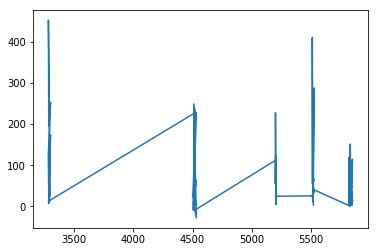

In [79]:
plt.plot(x,y)
plt.show()

In [64]:
df_clean = df_sorted.dropna(axis=0)

In [65]:
df_clean.head()

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
1861,Children's Education & Skills,Food Costs,M & D GRODZINSKI LTD,2015-01-05,3036.0,313.65
3169,Children's Family Services,Travelling Expenses,TFL OYST PHOTOCARD,2015-01-05,3040.0,10.00
1833,Children's Family Services,Other Transfer Payments to Soc,LOVE2REWARD.CO.UK,2015-01-05,3038.0,506.00
204,Children's Family Services,Equipment and Materials Purcha,"AMAZON SVCS EUROPE,SAR",2015-01-05,3043.0,9.98
3472,Children's Service DSG,Equipment and Materials Purcha,WWW.CONNEVANS.COM,2015-01-05,3039.0,220.95


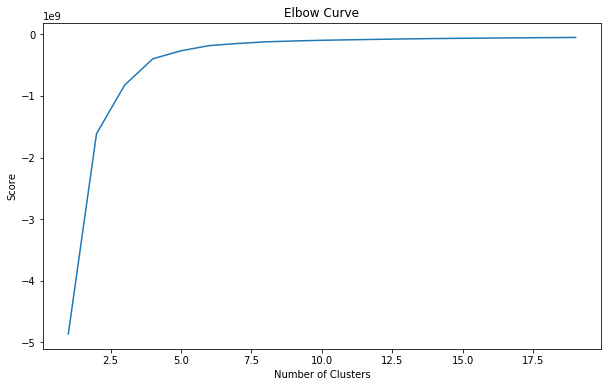

In [67]:
from sklearn.cluster import KMeans
data = df_clean[['Journal Reference', 'Total']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

In [80]:
X = df_clean[['Journal Reference', 'Total']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=5)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

NameError: name 'Axes3D' is not defined

<Figure size 504x504 with 0 Axes>